# Florida Voted for Four More Years of Trump... and a $15 Minimum Wage

Devin Barkey

Updated in April 2021 to include k-means clustering, geospatial visualizations, and make other minor edits:

- Calculated two-party presidential vote share rather than total vote share
- Used `np.asanyarray(X)` instead of `np.array(X).reshape(-1,1)` when creating variables for regression

Among the most surprising results from the 2020 general election was the passage of a gradual minimum wage increase in Florida, a state in which Republicans have dominated statewide elections as of late. The minimum wage amendment cleared the required 60% threshhold with 60.8% support, well above President Trump's 51.2% victory over his $15-minimum-wage-supporting opponent, President Biden. To examine these contrasting results, let's scrape the election results from the Florida Division of Elections website and then analyze them using data visualization, regression, and clustering tools in Python.

To do this, in addition to `numpy` for arrays, we use the `pandas` library for its `read_html` function and `DataFrame` structure, `requests` for accessing the html of the webpage, `matplotlib` and `seaborn` for visualizations, `sklearn` (better known as scikit-learn) for regression and clustering, and `geopandas` for geospatial data. 

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import geopandas as gpd

## Data Acquisition and Preparation

To get the results from the Florida Division of Elections website using `read_html`, we make use of a trick outlined in this [Stack Overflow post](https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html).

In [2]:
url1 = "http://results.elections.myflorida.com/DetailRpt.Asp?ELECTIONDATE=11/3/2020&RACE=PRE&PARTY=&DIST=&GRP=&DATAMODE="
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r1 = requests.get(url1, headers = header)
pres = pd.read_html(r1.text, skiprows = 1, header = 0)[0]

In [3]:
pres

,County,Trump / Pence(REP),Biden / Harris(DEM),Jorgensen / Cohen(LPF),De La Fuente / Richardson(REF),La Riva / Freeman(PSL),Hawkins / Walker(GRE),Blankenship / Mohr(CPF),Carroll / Patel(WRI),Howard / Howard(WRI),Laboch / Pope(WRI),Simmons / Nixon(WRI),Walls-Windhauser / Tolbert(WRI),Wells / Wells(WRI),Unnamed: 14
0,Alachua,50972,89704,1390,70,94,302,52,16,0,0,3,0,1,NaN
1,Baker,11911,2037,93,4,3,10,1,0,0,0,0,0,0,NaN
2,Bay,66097,25614,1004,54,45,142,52,11,0,0,5,0,0,NaN
3,Bradford,10334,3160,110,7,3,11,6,1,0,0,0,0,0,NaN
4,Brevard,207883,148549,3178,222,164,553,171,36,0,0,8,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Walton,32947,10338,336,16,15,43,13,1,0,0,2,0,0,NaN
66,Washington,9876,2347,69,5,10,15,5,0,0,0,0,0,0,NaN
67,Total,5668731,5297045,70324,5966,5712,14721,3902,854,9,1,181,2,8,NaN
68,% Votes,51.2%,47.9%,0.6%,0.1%,0.1%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,NaN


We clean this up a bit by dropping the `Total` and `% Votes` rows as well as the extra row and column included. In addition, we set the index to the `County` column and make sure all the other entries are `int`s. 

In [4]:
pres.drop(index = [67,68,69], columns = 'Unnamed: 14', inplace = True)
pres.loc[pres['County'] == 'Desoto', 'County'] = 'DeSoto'#Need to do this as the shapefile in the geospatial visualization section lists 'DeSoto' as the county name
pres.set_index('County', inplace = True)
pres = pres.astype(int)
pres

,Trump / Pence(REP),Biden / Harris(DEM),Jorgensen / Cohen(LPF),De La Fuente / Richardson(REF),La Riva / Freeman(PSL),Hawkins / Walker(GRE),Blankenship / Mohr(CPF),Carroll / Patel(WRI),Howard / Howard(WRI),Laboch / Pope(WRI),Simmons / Nixon(WRI),Walls-Windhauser / Tolbert(WRI),Wells / Wells(WRI)
County,,,,,,,,,,,,,
Alachua,50972,89704,1390,70,94,302,52,16,0,0,3,0,1
Baker,11911,2037,93,4,3,10,1,0,0,0,0,0,0
Bay,66097,25614,1004,54,45,142,52,11,0,0,5,0,0
Bradford,10334,3160,110,7,3,11,6,1,0,0,0,0,0
Brevard,207883,148549,3178,222,164,553,171,36,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Union,5133,1053,42,4,3,5,5,0,0,0,0,0,0
Volusia,173821,130575,2156,160,173,390,141,19,0,0,4,0,0
Wakulla,12874,5351,135,10,6,18,10,0,0,0,0,0,0


Next, we create two new columns: one for the total votes cast in a county in the presidential election and the other for President Trump's share of that vote.

In [5]:
pres['Total_pres_two_party'] = pres['Trump / Pence(REP)'] + pres['Biden / Harris(DEM)']
pres['Trump_pct'] = (pres['Trump / Pence(REP)']/pres['Total_pres_two_party'] * 100).round(2)
pres['Biden_pct'] = (pres['Biden / Harris(DEM)']/pres['Total_pres_two_party'] * 100).round(2)

Turning to the minimum wage amendment, we use the same process as above to read those results into a `pandas` `DataFrame` and tidy them up.

In [6]:
url2 = "http://results.elections.myflorida.com/DetailRpt.Asp?ELECTIONDATE=11/3/2020&RACE=A02&PARTY=&DIST=&GRP=&DATAMODE="
r2 = requests.get(url2, headers = header)
min_wage = pd.read_html(r2.text, skiprows = 1, header = 0)[0]
min_wage.drop(index = [67,68,69], columns = 'Unnamed: 3', inplace = True)
min_wage.loc[min_wage['County'] == 'Desoto', 'County'] = 'DeSoto'#Need to do this as the shapefile in the geospatial visualization section lists 'DeSoto' as the county name
min_wage.set_index('County', inplace = True)
min_wage.rename(columns = {'Unnamed: 1': 'Yes', 'Unnamed: 2': 'No'}, inplace = True)
min_wage = min_wage.astype(int)
min_wage

,Yes,No
County,,
Alachua,88302,51751
Baker,4106,9661
Bay,41100,50210
Bradford,4913,8353
Brevard,190619,155353
...,...,...
Union,2147,3989
Volusia,166151,126925
Wakulla,7235,10810


Again, we create new columns to use in the analysis.

In [7]:
min_wage['Total_min_wage'] = min_wage['Yes'] + min_wage['No']
min_wage['Yes_pct'] = (min_wage['Yes']/min_wage['Total_min_wage'] * 100).round(2)
min_wage['No_pct'] = (min_wage['No']/min_wage['Total_min_wage'] * 100).round(2)
min_wage

,Yes,No,Total_min_wage,Yes_pct,No_pct
County,,,,,
Alachua,88302,51751,140053,63.05,36.95
Baker,4106,9661,13767,29.82,70.18
Bay,41100,50210,91310,45.01,54.99
Bradford,4913,8353,13266,37.03,62.97
Brevard,190619,155353,345972,55.10,44.90
...,...,...,...,...,...
Union,2147,3989,6136,34.99,65.01
Volusia,166151,126925,293076,56.69,43.31
Wakulla,7235,10810,18045,40.09,59.91


We then join these two `DataFrames` using the `pandas` `join()` function. 

In [8]:
fl_2020 = pres.join(min_wage)
fl_2020

,Trump / Pence(REP),Biden / Harris(DEM),Jorgensen / Cohen(LPF),De La Fuente / Richardson(REF),La Riva / Freeman(PSL),Hawkins / Walker(GRE),Blankenship / Mohr(CPF),Carroll / Patel(WRI),Howard / Howard(WRI),Laboch / Pope(WRI),...,Walls-Windhauser / Tolbert(WRI),Wells / Wells(WRI),Total_pres_two_party,Trump_pct,Biden_pct,Yes,No,Total_min_wage,Yes_pct,No_pct
County,,,,,,,,,,,,,,,,,,,,,
Alachua,50972,89704,1390,70,94,302,52,16,0,0,...,0,1,140676,36.23,63.77,88302,51751,140053,63.05,36.95
Baker,11911,2037,93,4,3,10,1,0,0,0,...,0,0,13948,85.40,14.60,4106,9661,13767,29.82,70.18
Bay,66097,25614,1004,54,45,142,52,11,0,0,...,0,0,91711,72.07,27.93,41100,50210,91310,45.01,54.99
Bradford,10334,3160,110,7,3,11,6,1,0,0,...,0,0,13494,76.58,23.42,4913,8353,13266,37.03,62.97
Brevard,207883,148549,3178,222,164,553,171,36,0,0,...,0,0,356432,58.32,41.68,190619,155353,345972,55.10,44.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Union,5133,1053,42,4,3,5,5,0,0,0,...,0,0,6186,82.98,17.02,2147,3989,6136,34.99,65.01
Volusia,173821,130575,2156,160,173,390,141,19,0,0,...,0,0,304396,57.10,42.90,166151,126925,293076,56.69,43.31
Wakulla,12874,5351,135,10,6,18,10,0,0,0,...,0,0,18225,70.64,29.36,7235,10810,18045,40.09,59.91


## Data Visualization

Before fitting a linear regression model, we can first examine the correlation between the incumbent's share of the vote and the share of Floridians who voted "Yes" on the minimum wage amendment. We can visualize this data with a simple scatterplot:

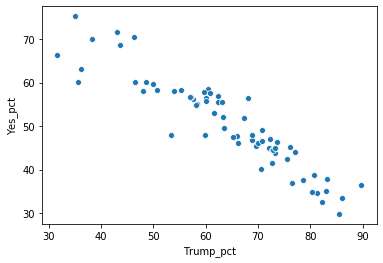

In [9]:
sns.scatterplot(data = fl_2020,  x = 'Trump_pct', y = 'Yes_pct')

As expected, we see a strong positive linear correlation between a county's level of support for President Trump and the level of support for the amendment. To be more accurate, we calculate the correlation coefficient $R$, which confirms our initial appraisal:

In [10]:
fl_2020['Trump_pct'].corr(fl_2020['Yes_pct'])

-0.9265555297123264

## Linear Regression

To further describe and model this relationship, we create a Linear Regression object, fit it using the presidential and minimum wage amendment results, and output the regression coefficients.

In [11]:
lm = LinearRegression()
X = np.asanyarray(fl_2020[['Trump_pct']])
y = fl_2020['Yes_pct']
lm.fit(X, y)
print(lm.coef_)
print(lm.intercept_)

[-0.69796611]
95.26009204365013


We can also add our linear model to the scatterplot using the `regplot` function.

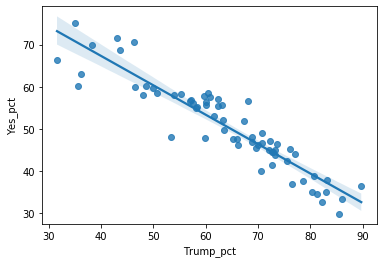

In [12]:
sns.regplot(data = fl_2020, x = 'Trump_pct', y = 'Yes_pct')

From the slope of our linear model (the value of `lm.coef_`), we find that on average for every one point increase in President Trump's share of the presidential vote we see only a 0.7 point decrease in the vote for the minimum wage amendment. We can also calculate the coefficient of determination, or $R^2$:

In [13]:
lm.score(X, y)

0.8585051496404901

## Identifying Some Interesting Counties

This shows that almost 86% of the variation of a county's support for the minimum wage amendment can be explained by its support of President Trump. What accounts for the other 14%? For a head start on answering this question, we can find which counties strayed the most from the linear model. To do this, we calculate the residual for each county and sort. 

In [14]:
res = (y - lm.predict(X)).sort_values(ascending = False)

At the top are counties in which the support for the minimum wage amendment was above what our model expected:

In [15]:
res.head()

County
Sumter        8.839319
Miami-Dade    7.612719
Osceola       6.323390
Flagler       5.491959
Martin        5.329034
Name: Yes_pct, dtype: float64

And at the bottom, we find counties where our model predicted higher support for the amendment than it in fact received.

In [16]:
res.tail()

County
Wakulla      -5.865766
Gadsden      -6.767383
Alachua      -6.922780
Jefferson    -9.899844
Leon        -10.239682
Name: Yes_pct, dtype: float64

## K-Means Clustering

We can also explore the results by grouping counties together based on similar results. More specifically, we will use k-means clustering to put the counties into 4 different groups based on their presidential and minimum wage amendment results. Note we chose `n = 4` but could do this with any number of clusters. Here, we use President Biden's share of the vote for a more direct comparison when looking at the cluster centers.

In [17]:
n = 4
X_kmeans = fl_2020[['Biden_pct', 'Yes_pct']]
kmeans = KMeans(n_clusters = n, random_state = 0).fit(X_kmeans)

In [18]:
fl_2020['cluster'] = kmeans.labels_

We can include our cluster assignments in the scatterplot using the code below:

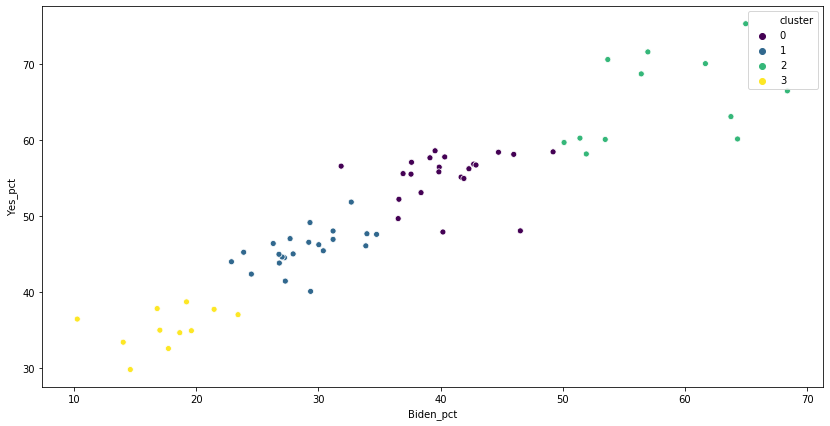

In [19]:
plt.figure(figsize = (14, 7))
sns.scatterplot(data = fl_2020,  x = 'Biden_pct', y = 'Yes_pct', hue = 'cluster', palette = 'viridis')

In [20]:
kmeans.cluster_centers_

array([[40.56636364, 55.28272727],
       [28.83181818, 45.67181818],
       [58.09583333, 65.30583333],
       [17.52272727, 35.28454545]])

For each cluster, the mean minimum wage amendment vote share was considerably higher than the mean Biden vote share. In fact, for three of the clusters, the difference was 15 points or more, and for one cluster, the mean amendment vote share was twice that of the Biden vote share.

# Geospatial Visualizations

Let's also look at what these clusters look like geographically. To do that, we can download a shapefile containing the Florida county lines from the [Census website](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) and use the `geopandas` library to read it into a `GeoDataFrame`.

In [21]:
counties_path = "/Users/devinbarkey/Documents/Projects/cb_2019_us_all_20m/cb_2019_us_county_20m/cb_2019_us_county_20m.shp"
counties = gpd.read_file(counties_path)

In [22]:
fl_counties = counties[counties['STATEFP'] == '12']

In [23]:
fl_counties

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
33,12,081,00295744,0500000US12081,12081,Manatee,06,1925994820,386168924,"POLYGON ((-82.71985 27.52893, -82.65072 27.523..."
136,12,047,00295736,0500000US12047,12047,Hamilton,06,1330689567,13659798,"POLYGON ((-83.30935 30.63424, -83.13662 30.623..."
308,12,027,00294452,0500000US12027,12027,DeSoto,06,1649027549,6243548,"POLYGON ((-82.05650 27.20777, -82.05575 27.338..."
367,12,001,00308548,0500000US12001,12001,Alachua,06,2267634813,241567998,"POLYGON ((-82.65855 29.83014, -82.64063 29.828..."
425,12,115,00295741,0500000US12115,12115,Sarasota,06,1439998180,438480422,"POLYGON ((-82.64817 27.38972, -82.25226 27.386..."
...,...,...,...,...,...,...,...,...,...,...
2885,12,039,00306918,0500000US12039,12039,Gadsden,06,1337233845,31646697,"POLYGON ((-84.93252 30.60639, -84.86094 30.693..."
2976,12,077,00308549,0500000US12077,12077,Liberty,06,2164099094,19582444,"POLYGON ((-85.11566 30.19998, -85.03429 30.312..."
3069,12,125,00306913,0500000US12125,12125,Union,06,630804540,16049423,"POLYGON ((-82.57599 29.99086, -82.45836 30.136..."
3186,12,089,00295730,0500000US12089,12089,Nassau,06,1680074659,200051074,"POLYGON ((-82.05098 30.36837, -82.04077 30.370..."


In [24]:
fl_counties.set_index('NAME', inplace = True)
fl_counties.index.rename('County', inplace = True)

We can then merge the `fl_counties` `GeoDataFrame` with the `fl_2020` `DataFrame` so that we have access to both the `geometry` of the counties as well as the `cluster` assignments. Then we can simply plot and set the column of interest to `cluster`.

In [25]:
fl_counties = fl_counties.merge(fl_2020, on = 'County')

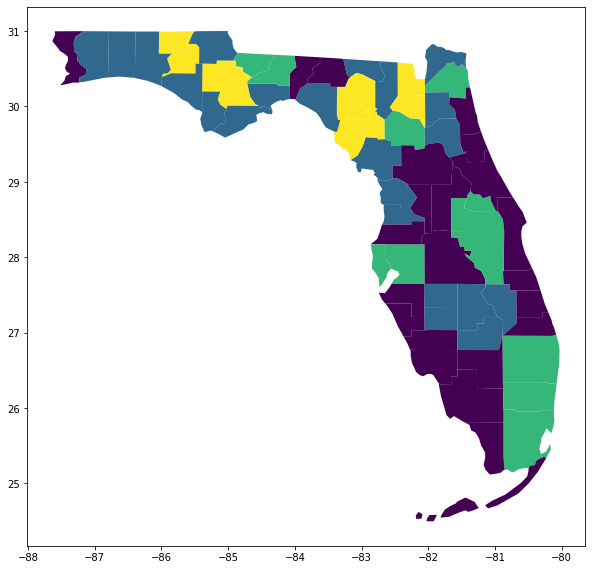

In [26]:
fl_counties.plot(figsize = (10,10), column = 'cluster')

Of course, this looks very similar to a plot of Joe Biden's support throughout the state:

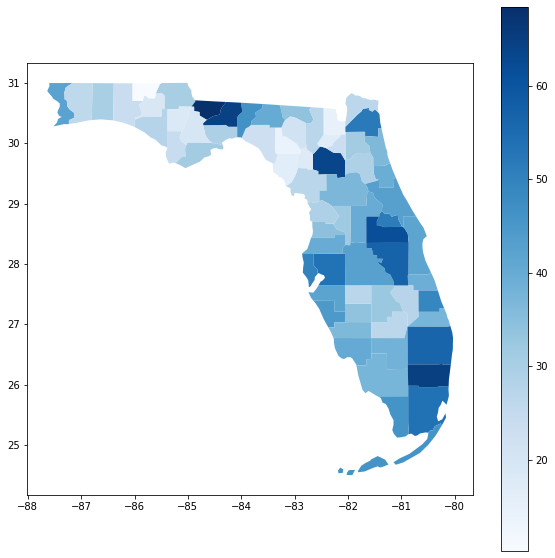

In [27]:
fl_counties.plot(figsize = (10,10),column = 'Biden_pct', legend = True, cmap = 'Blues')

These results provide but a starting point in a quest to understand why a red-tinged state voted in favor of a rallying cry of the progressive agenda.